
sources: 
* [tutorial by Mauro Di Pietro, 2020](https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec)
* [tutorial by Rafi Atha, 2021](https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b)


TODO: 
* see also data science of EEG , correlation 
* use tutorials: 
https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
* https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
* https://towardsdatascience.com/how-to-run-30-machine-learning-models-with-2-lines-of-code-d0f94a537e52
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


## Load data

In [273]:
from google.colab import files, drive
import pandas as pd

In [274]:
drive.mount('/content/drive')

def read_data(data_name): 

  data_path = "/content/drive/MyDrive/eeg_data_science/Results/5.For_Modeling/"
  return pd.read_csv(data_path + data_name +'.csv')

X = read_data('X')
y = read_data('y')
X_raw = X
y_raw = y

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prapere for modeling

In [275]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import random
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, tree, naive_bayes, neighbors, svm
## for explainer
!pip install lime
from lime import lime_tabular
!pip install shap
import shap

Text(0.5, 1.0, 'Class Distribution')

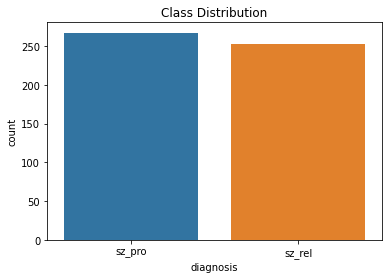

In [276]:
ax = sns.countplot(x="diagnosis", data=y_raw)
plt.title("Class Distribution")

In [277]:
X_raw.isnull().sum().sum()

0

In [278]:
X = X.drop(columns=['Unnamed: 0'])
y = y.drop(columns=['Unnamed: 0'])

In [279]:
f'Data is consist of {X.shape[0]} examples with {+X.shape[1]} features each.'

'Data is consist of 520 examples with 170 features each.'

In [280]:
from sklearn.preprocessing import StandardScaler

X_scaled = X.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

diag_map = {'sz_pro': 1, 'sz_rel': 0}
y_dummy = y['diagnosis'].map(diag_map)

X_safe = X
y_safe = y_dummy

def default_data():
  
  feature_names = X_safe.columns
  X = X_scaled
  y = y_safe

  return X, y, feature_names

## Statistics

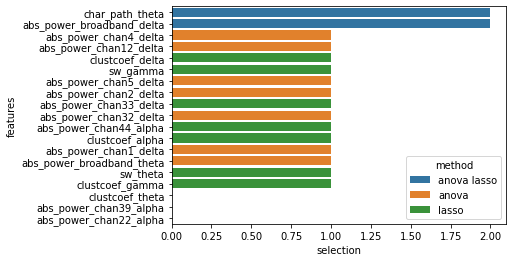

In [281]:
X, y, feature_names = default_data()

## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]

## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False)[1:20], dodge=False) 

# Modeling

In [326]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

models_results = pd.DataFrame(columns=['Metric', 'Score', 'Model'])
models = {}

In [283]:
def train_test_eval(model_name, model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  print('\033[1m' + 'Model'+'\033[0m')
  display(model)
  print()

  # test 
  results = evaluate_model(model, X_test, y_test)

  # show result
  print('\033[1m' + 'Results'+'\033[0m')
  cm_pos = list(results['Metric'].values()).index('cm')
  plot_confusion_matrix(results['Score'][cm_pos], model_name)

  # save results 
  del results['Metric'][cm_pos]
  del results['Score'][cm_pos]

  res_df = pd.DataFrame(results)
  res_df.insert(2, "Model", model_name)
  display(res_df)
  return res_df

In [284]:
def evaluate_model(model, X_test, y_test):
# source: https://gist.github.com/rafiag/350ec2dee0fb311d3342197b6c8424b5#file-evaluation_function-py

    # Predict Test Data 
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    if  hasattr(model, 'name'): 
      if model.name == 'LinearSVC': 
        y_pred_proba = model.decision_function(X_test) 
    else: 
      y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    results = {'Metric': {0: 'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1', 4: 'Kappa', 5: 'fpr', 6: 'tpr', 7: 'AUC', 8: 'cm'}, 
               'Score': {0: acc, 1: prec, 2: rec, 3: f1, 4: kappa, 5: [fpr],  6: [tpr], 7: auc, 8: cm}} 
    return results

In [285]:
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_confusion_matrix(cm, classifier):

  classes = ['sz_rel', 'sz_pro']
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', cmap=random.choice(cmaps), cbar=False)
  ax.set(xlabel="Predicted", ylabel="True", title=f"Confusion Matrix - {classifier}")
  ax.set_yticklabels(labels=classes, rotation=0)
  ax.set_xticklabels(labels=classes)
  plt.show()

## SVM

Model


Liblinear failed to converge, increase the number of iterations.


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Results


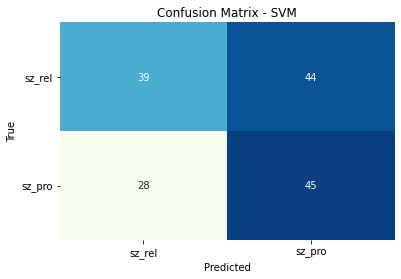

,Metric,Score,Model
0,Accuracy,0.538462,SVM
1,Precision,0.505618,SVM
2,Recall,0.616438,SVM
3,F1,0.555556,SVM
4,Kappa,0.085193,SVM
5,fpr,"[[0.0, 0.012048192771084338, 0.012048192771084...",SVM
6,tpr,"[[0.0, 0.0, 0.0958904109589041, 0.095890410958...",SVM
7,AUC,0.613798,SVM


In [327]:
model = svm.LinearSVC()
model.name = 'LinearSVC'
models['SVM'] = model
results = train_test_eval('SVM', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Logistic regression

Model


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


Results


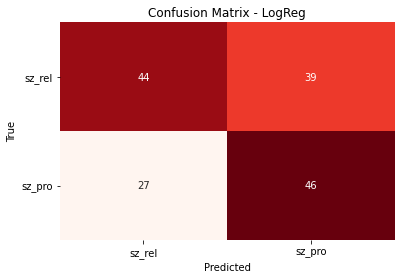

,Metric,Score,Model
0,Accuracy,0.576923,LogReg
1,Precision,0.541176,LogReg
2,Recall,0.630137,LogReg
3,F1,0.582278,LogReg
4,Kappa,0.158686,LogReg
5,fpr,"[[0.0, 0.0, 0.0, 0.012048192771084338, 0.01204...",LogReg
6,tpr,"[[0.0, 0.0684931506849315, 0.0821917808219178,...",LogReg
7,AUC,0.591682,LogReg


In [329]:
model = linear_model.SGDClassifier(loss='log')
models['LogReg'] = model
results = train_test_eval('LogReg', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Decision Tree

Model


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Results


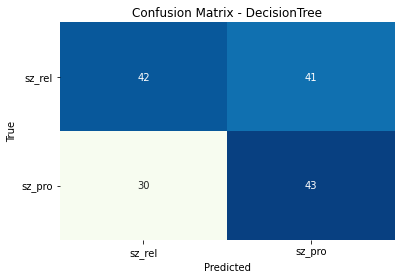

,Metric,Score,Model
0,Accuracy,0.544872,DecisionTree
1,Precision,0.511905,DecisionTree
2,Recall,0.589041,DecisionTree
3,F1,0.547771,DecisionTree
4,Kappa,0.09421,DecisionTree
5,fpr,"[[0.0, 0.4939759036144578, 1.0]]",DecisionTree
6,tpr,"[[0.0, 0.589041095890411, 1.0]]",DecisionTree
7,AUC,0.547533,DecisionTree


In [330]:
model = tree.DecisionTreeClassifier()
models['DecisionTree'] = model
results = train_test_eval('DecisionTree', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Random Forest

Model


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Results


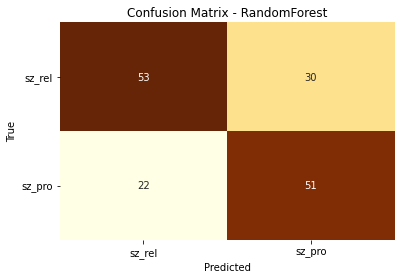

,Metric,Score,Model
0,Accuracy,0.666667,RandomForest
1,Precision,0.62963,RandomForest
2,Recall,0.69863,RandomForest
3,F1,0.662338,RandomForest
4,Kappa,0.334973,RandomForest
5,fpr,"[[0.0, 0.0, 0.0, 0.012048192771084338, 0.01204...",RandomForest
6,tpr,"[[0.0, 0.0136986301369863, 0.1095890410958904,...",RandomForest
7,AUC,0.732217,RandomForest


In [331]:
model = ensemble.RandomForestClassifier()
models['RandomForest'] = model
results = train_test_eval('RandomForest', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

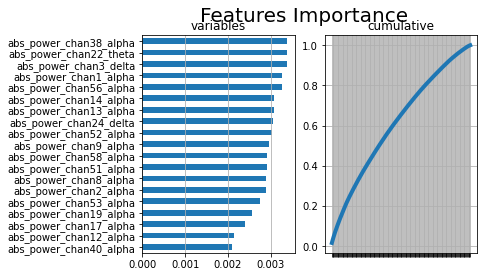

In [296]:
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE")[1:N_features].plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels='')
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

## Gradient Boosting 

In [291]:
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=100, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 1, 'n_estimators': 1500, 'min_samples_split': 60, 'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 5, 'learning_rate': 0.01}
Best Model mean accuracy: 0.6674657534246575


scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


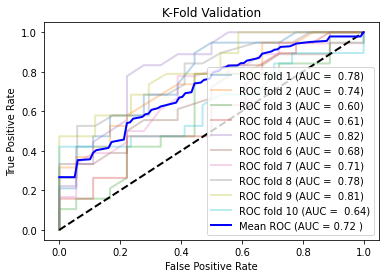

In [211]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
   prediction = model.fit(X_train[train],y_train.iloc[train]).predict_proba(X_train[test])
   fpr, tpr, t = metrics.roc_curve(y_train.iloc[test], prediction[:, 1])
   tprs.append(scipy.interp(mean_fpr, fpr, tpr))
   roc_auc = metrics.auc(fpr, tpr)
   aucs.append(roc_auc)
   plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC =  %0.2f)' % (i, roc_auc))
   i = i+1
   
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

Model


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Results


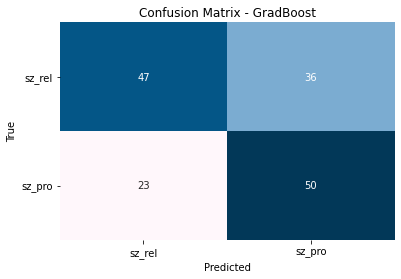

,Metric,Score,Model
0,Accuracy,0.621795,GradBoost
1,Precision,0.581395,GradBoost
2,Recall,0.684932,GradBoost
3,F1,0.628931,GradBoost
4,Kappa,0.24853,GradBoost
5,fpr,"[[0.0, 0.0, 0.0, 0.0, 0.012048192771084338, 0....",GradBoost
6,tpr,"[[0.0, 0.0136986301369863, 0.0410958904109589,...",GradBoost
7,AUC,0.688067,GradBoost


In [332]:
models['GradBoost'] = model
results = train_test_eval('GradBoost', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Naive Bayes

Model


GaussianNB(priors=None, var_smoothing=1e-09)


Results


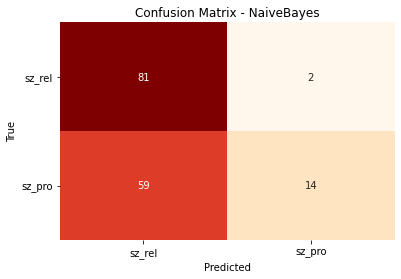

,Metric,Score,Model
0,Accuracy,0.608974,NaiveBayes
1,Precision,0.875,NaiveBayes
2,Recall,0.191781,NaiveBayes
3,F1,0.314607,NaiveBayes
4,Kappa,0.175961,NaiveBayes
5,fpr,"[[0.0, 0.0, 0.0, 0.024096385542168676, 0.02409...",NaiveBayes
6,tpr,"[[0.0, 0.136986301369863, 0.1506849315068493, ...",NaiveBayes
7,AUC,0.569731,NaiveBayes


In [333]:
model = naive_bayes.GaussianNB()
models['NaiveBayes'] = model
results = train_test_eval('NaiveBayes', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## K-Nearest Neighbors

Model


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


Results


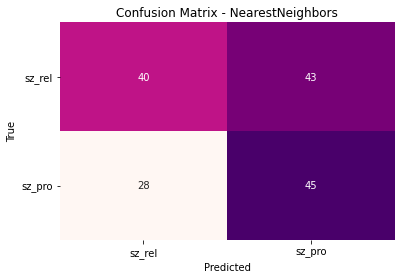

,Metric,Score,Model
0,Accuracy,0.544872,NearestNeighbors
1,Precision,0.511364,NearestNeighbors
2,Recall,0.616438,NearestNeighbors
3,F1,0.559006,NearestNeighbors
4,Kappa,0.0971634,NearestNeighbors
5,fpr,"[[0.0, 0.04819277108433735, 0.2168674698795180...",NearestNeighbors
6,tpr,"[[0.0, 0.0684931506849315, 0.3561643835616438,...",NearestNeighbors
7,AUC,0.592672,NearestNeighbors


In [334]:
model = neighbors.KNeighborsClassifier()
models['NearestNeighbors'] = model
results = train_test_eval('NearestNeighbors', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

# Model Comparison

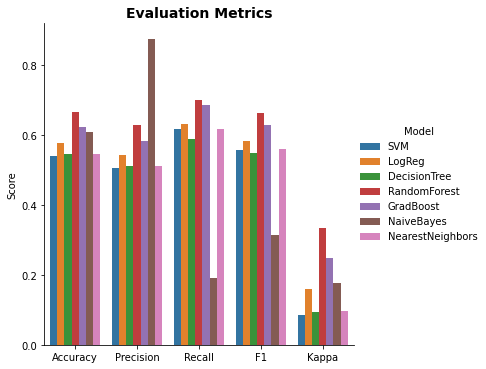

In [335]:
# Scores

cols_scores = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
data_scores = models_results[models_results['Metric'].isin(cols_scores)]
sn = sns.catplot(
    data=data_scores, kind="bar",
    x="Metric", y="Score", hue="Model",
)
sn.set_axis_labels("", "Score")

plt.title('Evaluation Metrics', fontsize=14, fontweight='bold')

plt.show()

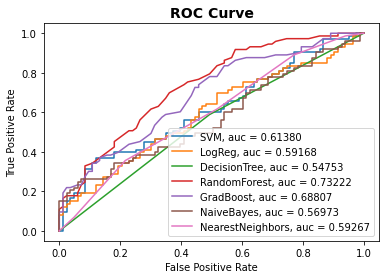

In [336]:
# ROCs

model_names = models_results['Model'].unique()
for m in model_names:
  fpr = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['fpr']))]['Score']
  tpr = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['tpr']))]['Score']
  auc = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['AUC']))]['Score']
  plt.plot(list(fpr)[0][0], list(tpr)[0][0], label='{}, auc = {:0.5f}'.format(m, auc.item()))

## Configure x and y axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Create legend & title
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc=4)

plt.show()

# Results (Best Model)

--- TODO: should show results only for the best model 

In [337]:
auc = models_results.loc[(models_results['Metric'].isin(['AUC']))]
auc = auc.sort_values("Score", ascending=False)
best_model = auc['Model'].iloc[0]
f'best model is {best_model}'

'best model is RandomForest'

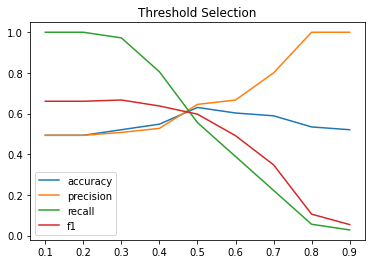

In [338]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
model = models[best_model]
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(title="Threshold Selection")
plt.show()

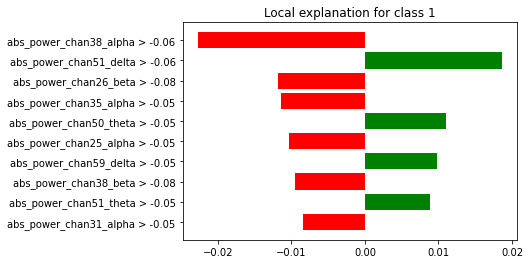

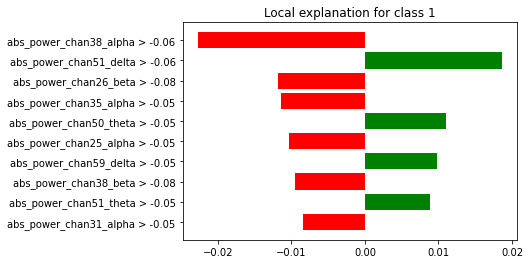

In [339]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=feature_names, class_names=np.unique(y_train), mode="classification")
explained = explainer.explain_instance(X_test[4], model.predict_proba, num_features=10)
explained.as_pyplot_figure()